In [1]:
import json
from datetime import datetime
from influxdb import InfluxDBClient
from decouple import config
import pandas as pd
import arrow

## Part1: A Python interface to access Link Lab data using InfluxQL

In [ ]:
'''' influxdb-python
REFERENCES:
    https://www.influxdata.com/blog/getting-started-python-influxdb/
    https://influxdb-python.readthedocs.io/en/latest/examples.html
    https://github.com/influxdata/influxdb-python
'''

In [ ]:
''''  influxdata 1.x - Explore data using InfluxQL
REFERENCES:
    https://docs.influxdata.com/influxdb/v1/query_language/explore-data/
'''

In [ ]:
''' General name of the sensor(device) type in Link Lab
    +------+------------+------------+---------------+--------------------+-------------+--------------------------+
    | Type | Awair Omni | LightLevel | Temp Humidity | LoRa Temp Humidity | Door Sensor | Setra Power Battalion 48 | 
    +------+------------+------------+---------------+--------------------+-------------+--------------------------+

REFERENCES:
    Link Lab Metadata: https://metadata.linklab.virginia.edu/
'''

In [2]:
class Influx():
    def __init__(self):
        self.user = config('INFLUXDB_USERNAME')
        self.password = config('INFLUXDB_PASSWORD')
        self.host = config('INFLUX_HOST')
        self.dbname = config('INFLUXDB_DATABASE_NAME') # 'linklab-users' or 'gateway-generic' 
        self.port = 443
        self.ssl = True
        self.client = self.get_client()
    
    def get_client(self):
        client = InfluxDBClient(host=self.host, port=self.port, username=self.user,
                                password=self.password, database=self.dbname, ssl=self.ssl)
#         print('Retrieving client for: %s' % dbname)
        self.client = client
        return client
    
    def __str__(self):
        return str(self.__class__.__dict__)

    def get_device_query_adds(self, device_id_list):
        q_append = ''
        count = 0
        for device_id in device_id_list:
            if count == 0:
                q_append += 'and ("device_id"=\'%s\'' % device_id
            else:
                q_append += 'or "device_id"=\'%s\'' % device_id
            count += 1
        q_append += ')'
        return q_append
    
    def get_result_set(self, fieldname, add_param):  # show in new readme
        q_str = 'SELECT * FROM "%s" WHERE %s' % (fieldname, add_param)
#         print(q_str)
        client = self.client
        result_set = client.query(q_str)
        return result_set
    
    def get_result_set_from_custom_q_str(self, q_str):
        print(q_str)
        client = self.client
        result_set = client.query(q_str)
        return result_set
    
    def convert_influx_time_to_datetime(self,time_str, timezone):
        t = arrow.Arrow.strptime(time_str[:19], '%Y-%m-%dT%H:%M:%S')
        return t.to(timezone).datetime  # utc.to('local').datetime
    
    def get_longform_df(self,result_set, timezone='US/Eastern'):
        # essentially converting the result set to long_form
        df = pd.DataFrame([pt for pt in result_set.get_points()])
        # convert the string time to datetime objects
        if 'time' in df.columns:
            df['time'] = df['time'].map(
                lambda x: self.convert_influx_time_to_datetime(x, timezone))
            return df
        else:
            return None
    
    
    # Access current (now()) timing value
    """ upload rate: 
    +------+------------+------------+---------------+--------------------+-------------+--------------------------+
    | Type | Awair Omni | LightLevel | Temp Humidity | LoRa Temp Humidity | Door Sensor | Setra Power Battalion 48 | 
    +------+------------+------------+---------------+--------------------+-------------+--------------------------+
    | Rate |   10s      |  30 min    |    15 min     |       05 min       |   20 min    |         1 min            |
    +------+------------+------------+---------------+--------------------+-------------+--------------------------+   
    """
    
    def get_time_query_from_now(self, device_type):
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        lookup = {
            "Awair" : "time > now() -1m ",
            "Light_Level": "time > now() -40m ",
            "Temp_Humid": "time > now() -20m ",
            "LoRa_Temp_Humid": "time > now() -15m ",
            "Door_Sensor":"time > now() -30m ",
            "Setra_Power_Battalion_48":"time > now() -6h ",
        }
#         print("Current Time:", current_time)
        tq = lookup.get(device_type, None)
        return tq    

In [3]:
def get_sensor_data(fieldname, device_id, device_type):
    x = Influx()
    a = x.get_time_query_from_now(device_type)
#     print('Retrieving device: %s, field: %s' % (device_id,fieldname))
    if device_id is not None:
        a += x.get_device_query_adds([device_id])
    r = x.get_result_set(fieldname, a)
    
    if x.get_longform_df(r) is None:
        # return None if there is no data after querying from influx
        return None 
    else: 
        # get the latest one if there is data
        return x.get_longform_df(r).tail(1) 

In [9]:
# insecure-requestwarnings-be-disabled-in-the-requests-module
from requests.packages import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### The Demo: General name of sensor (device) type in Link Lab
- [REFERENCES: Link Lab Metadata](https://metadata.linklab.virginia.edu/)

| Type | Awair Omni | LightLevel  | Temp Humidity | LoRa Temp Humidity  |  Door Sensor | Setra Power Battalion 48|
| -------- | -------- | -------- |-------- |-------- |-------- |-------- |
| Rate     | 10s    | 30 min     | 15 min | 5 min | 20 min | 1 min |
| ID started with     | 70886b    | 0506     | 018 | 24E124136 | 059 | ELEUV0202|
| Type naming in Python | Awair | Light_Level | Temp_Humid | Lora_Temp_Humid| Door_Sensor | Setra_Power_Battalion_48 |

In [4]:
""" Device Type == Awair Omni
"""
aw_res = get_sensor_data("Temperature_°C","70886b123507","Awair")
display(aw_res)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influx.linklab.virginia.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


,time,0,1,2,3,awair_device_uuid,awair_mac_address,controller_id,description,details,...,gateway_address,gateway_id,handler_id,location_area,location_general,location_specific,received_time,receiver,ttn_application_id,value
4,2024-08-18 05:39:22-04:00,None,None,None,None,awair-omni_12629,None,None,None,14,...,None,c0:98:e5:c0:00:38,None,None,UVA,217 Olsson,None,http-awairlocal-publish,None,24.05


In [5]:
""" Device Type == LightLevel
"""
light_level_res = get_sensor_data("Illumination_lx","0506dac8","Light_Level")
display(light_level_res)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influx.linklab.virginia.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


None

In [7]:
""" Device Type == Temp Humidity
""" 
temp_humid_res = get_sensor_data("Temperature_°C","018a4759","Temp_Humid")
display(temp_humid_res)

Retrieving device: 018a4759, field: Temperature_°C
SELECT * FROM "Temperature_°C" WHERE time > now() -20m and ("device_id"='018a4759')


,time,awair_device_uuid,awair_mac_address,controller_id,description,details,device_class,device_id,facilities_tag,gateway_address,gateway_id,handler_id,location_area,location_general,location_specific,received_time,receiver,ttn_application_id,value
0,2023-11-21 12:04:38-05:00,None,None,enocean-controller,Near door,TH-40,Range 0°C to +40°C and 0% to 100%,018a4759,None,None,dca63263a7c8,enocean-handler,None,UVA,283 Olsson,None,None,None,21.44


In [6]:
""" Device Type == LoRa Temp Humidity
""" 
lora_temp_humid_res = get_sensor_data("Temperature_°C","24E124136D324738","LoRa_Temp_Humid")
display(lora_temp_humid_res)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influx.linklab.virginia.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


,time,0,1,2,3,awair_device_uuid,awair_mac_address,controller_id,description,details,...,gateway_address,gateway_id,handler_id,location_area,location_general,location_specific,received_time,receiver,ttn_application_id,value
4,2024-08-18 05:51:28-04:00,None,None,None,None,None,None,None,Inside the wardrobe in the Gilmer 301.,dqb0m7uvj,...,None,eui-9cd47dfffe9e0450,None,None,UVA,GilmerHall-inside,None,http-ttn-mqtt,uva-engineers-way-sensors,23.4


In [9]:
""" Device Type == Door Sensor
""" 
door_sensor_res = get_sensor_data("rssi","0591ef8f","Door_Sensor")
display(door_sensor_res)

Retrieving device: 0591ef8f, field: rssi
SELECT * FROM "rssi" WHERE time > now() -30m and ("device_id"='0591ef8f')


,time,band_id,controller_id,description,details,device_class,device_id,gateway_address,gateway_id,handler_id,location_area,location_general,location_specific,platform,receiver,ttn_application_id,value
6,2023-11-21 12:05:05-05:00,None,None,On door from elevators to Link Lab,None,Single Input Contact,0591ef8f,None,c0:98:e5:c0:00:05,None,None,UVA,C210 Olsson,None,enocean-generic-gateway,None,79.0


In [12]:
""" Device Type == Setra Power Battalion 48
""" 
setra_power_battalion_48_res = get_sensor_data("voltage_v","ELEUV0202SM3Fc","Setra_Power_Battalion_48")
display(setra_power_battalion_48_res)

Retrieving device: ELEUV0202SM3Fc, field: voltage_v
SELECT * FROM "voltage_v" WHERE time > now() -6h and ("device_id"='ELEUV0202SM3Fc')


,time,description,details,device_id,facilities_tag,gateway_id,location_general,location_specific,receiver,value
149,2023-11-21 09:13:00-05:00,Receptacles,circuit 35,ELEUV0202SM3Fc,UVA/Data/Buildings/0202/ac_Buildings0202Meters...,joule.cs.virginia.edu,UVA,206 Olsson,facilities,121.967522


## Part2: A Python interface to check `device_status` in the Link Lab
###  General name of sensor (device) type in Link Lab
- [REFERENCES: Link Lab Metadata](https://metadata.linklab.virginia.edu/)

| Type | Awair Omni | LightLevel  | Temp Humidity | LoRa Temp Humidity  |  Door Sensor | Setra Power Battalion 48|
| -------- | -------- | -------- |-------- |-------- |-------- |-------- |
| Rate     | 10s    | 30 min     | 15 min | 5 min | 20 min | 1 min |
| ID started with     | 70886b    | 0506     | 018 | 24E124136 | 059 | ELEUV0202|
|check from field | Temperature_°C| Illumination_lx| Temperature_°C| Temperature_°C | rssi| voltage_v| 
| Type naming in Python | Awair | Light_Level | Temp_Humid | Lora_Temp_Humid| Door_Sensor | Setra_Power_Battalion_48 |


In [13]:
from pathlib import Path

In [14]:
# Device Mapping
# defining the device_types , MAC_Address <-> device_type
'''
def get_time_query_from_now(self, device_type):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    lookup = {
        "Awair" : "time > now() -1m ",
        "Light_Level": "time > now() -40m ",
        "Temp_Humid": "time > now() -20m ",
        "LoRa_Temp_Humid": "time > now() -15m ",
        "Door_Sensor":"time > now() -30m ",
        "Setra_Power_Battalion_48":"time > now() -6h ",
    }
'''
device_ids_lookup = {
    "Awair" : ["70886b"],
    "Light_Level": ["0506"],
    "Temp_Humid": ["018a","018317c3"],
    "LoRa_Temp_Humid": ["24E124136D"],
    "Door_Sensor": ["0591e","0591f","05920","01834", "01833", "0181"],
    "Setra_Power_Battalion_48": ["ELEUV0202"],
}

check_field_from_device_lookup = {
    "Awair" : "Temperature_°C",
    "Light_Level": "Illumination_lx",
    "Temp_Humid": "Temperature_°C",
    "LoRa_Temp_Humid": "Temperature_°C",
    "Door_Sensor": "rssi",
    "Setra_Power_Battalion_48": "voltage_v",
}

###  influxdata 1.x - Explore data using InfluxQL
REFERENCES:
    https://docs.influxdata.com/influxdb/v1/query_language/explore-data/

In [15]:
def influx_show_measurements():
    x = Influx()
    dbname = x.dbname
    q_str = 'SHOW MEASUREMENTS ON "%s"' % (dbname)
    result_set = x.get_result_set_from_custom_q_str(q_str)
    return result_set

def influx_show_tag_values():
    x = Influx()
    dbname = x.dbname
    q_str = 'SHOW TAG VALUES ON "%s" WITH KEY = "device_id"' % (dbname)
    result_set = x.get_result_set_from_custom_q_str(q_str)
    return result_set

# res = influx_show_tag_values()
# for pt in res.get_points():
#     print(pt)

### Pseudo
#### For registered devices in linklab.metadata (linklab.influx),  I want to know if devices' status from a certain type are on-or-off 
1. Get all devices that you request according to the device type
2. Data Query from influx
3. The retun after the query will be 'status_on_list' and 'status_off_list'

###  The information of all registered devices in linklab.metadata could be downloaded as a csv file

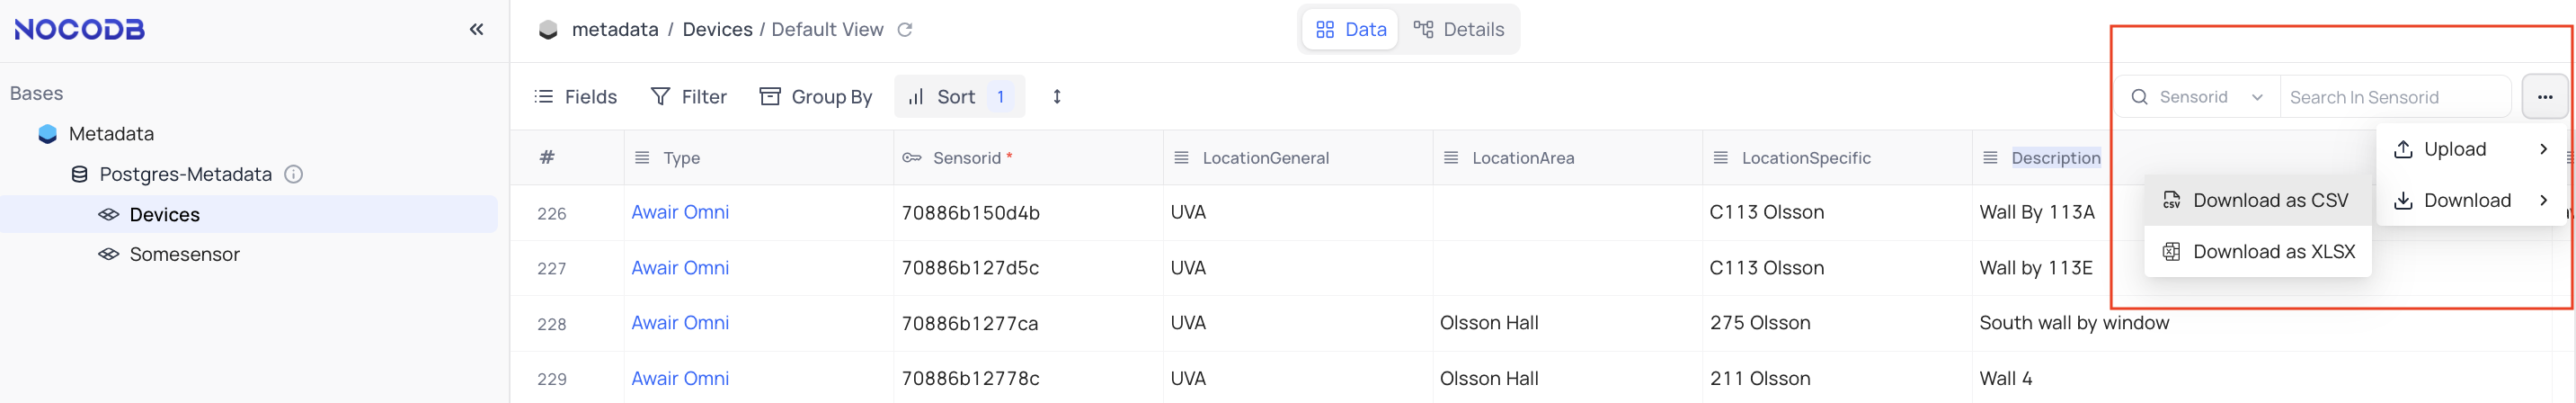

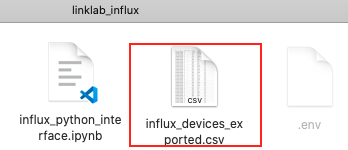

#### The Note
1. Type in linklab.metada is not a tag in linklab.influx
2. Altenately, use the 'device_id' as a reference to get certain devices
    - It is not secure to directly utilize Type in linklab.metdata (that column may be blank)
    - Given a device_type (named in Python naming convention)
    - Make use of the uniqueness of Sensorid in linklab.metadata (device_id in influx), find all devices that you request according to the device_type
3. in [linklab.Metadata](https://metadata.linklab.virginia.edu/)
    - Type has no matched tag in influx
    - Sesorid matches tag 'device_id' in influx

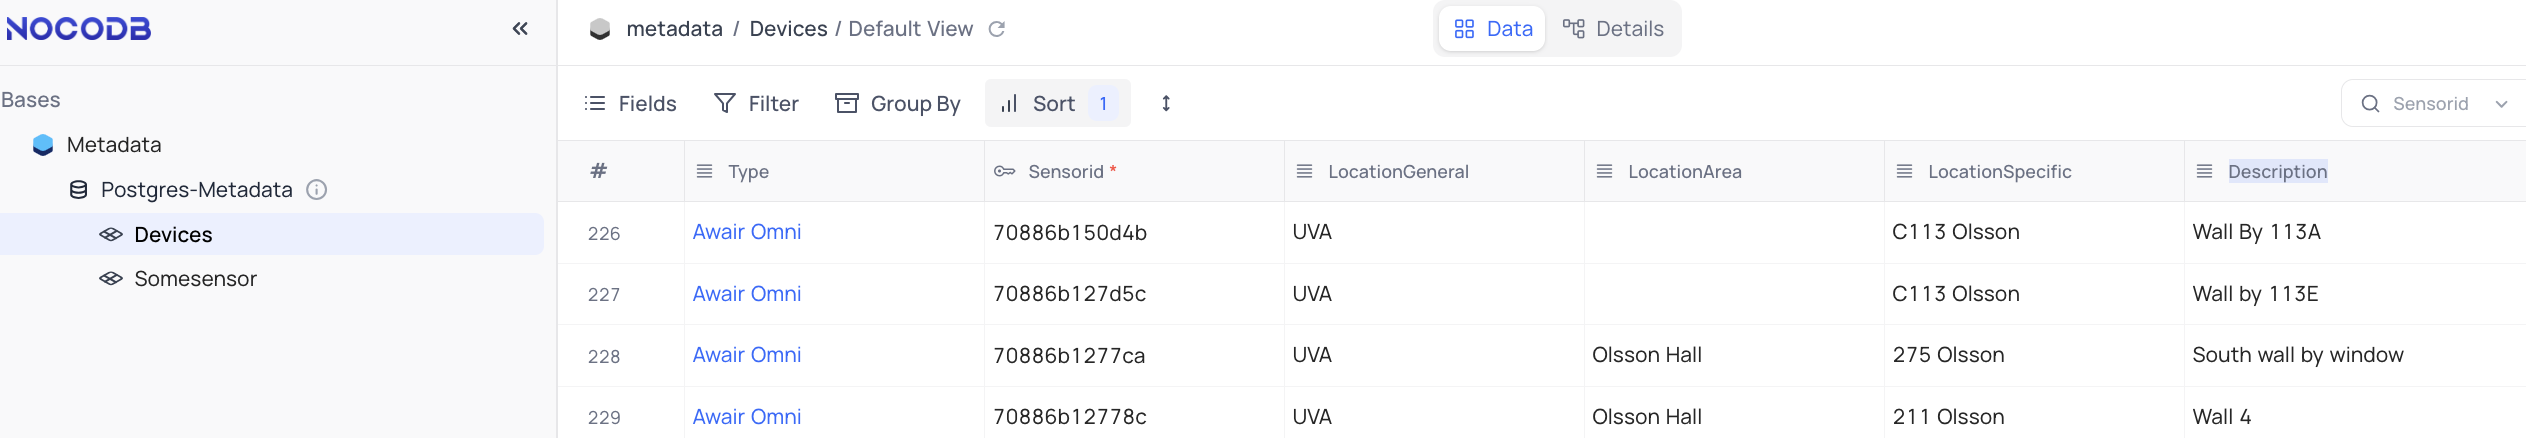

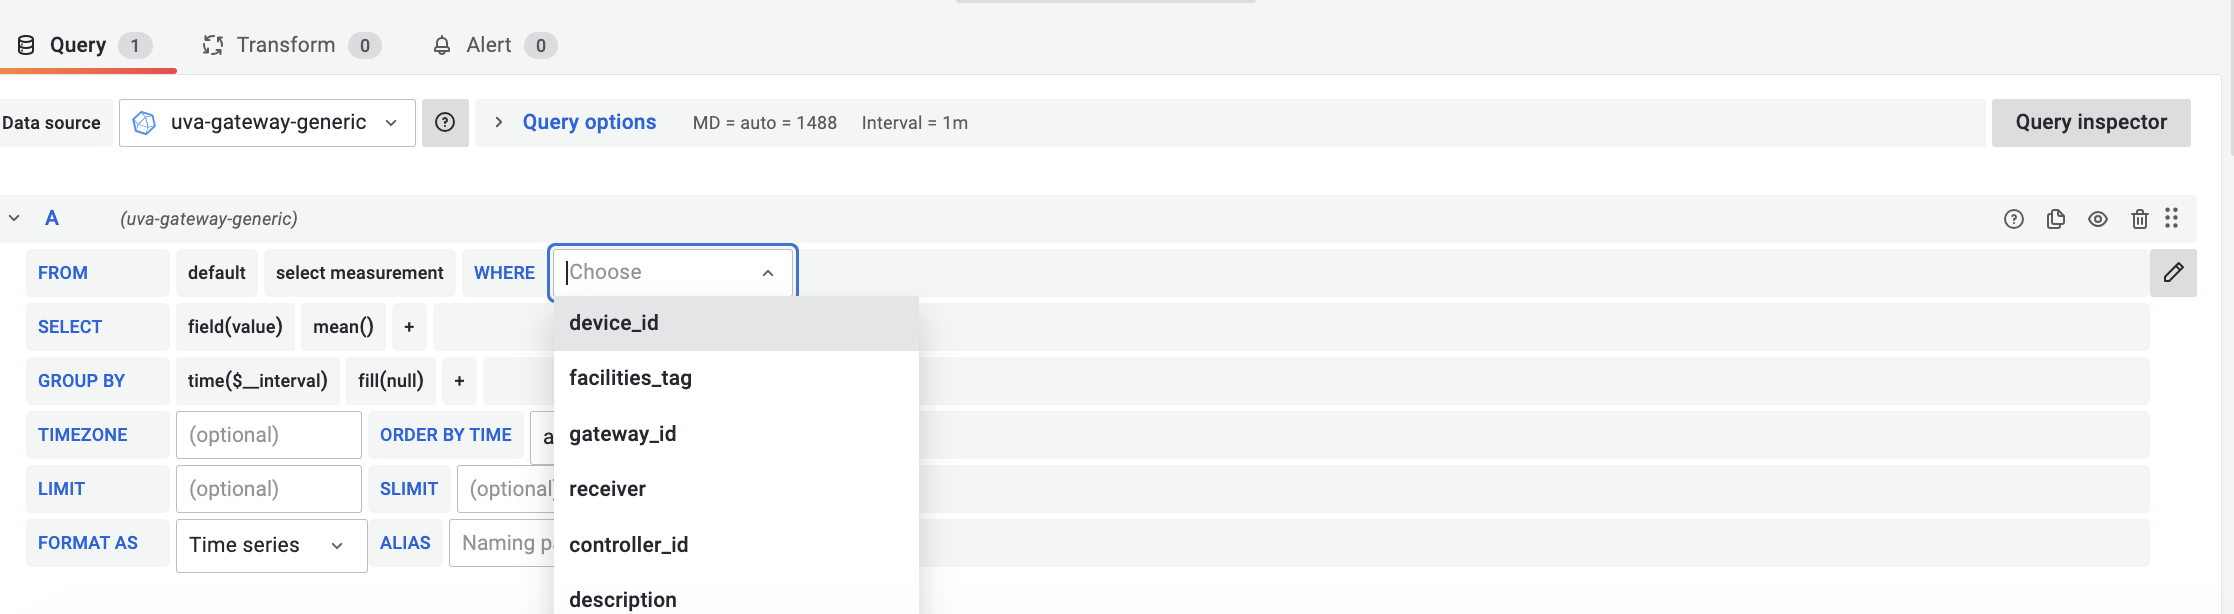

In [18]:
filepath = Path('influx_devices_exported.csv')
df = pd.read_csv(filepath)

### Step 1: Get all devices that you request according to the device type

In [19]:
def get_influx_devices_from_type(device_type):
    res = {}
    for idx , row in df.iterrows():
        for device_id_lookup in device_ids_lookup[device_type]:
            if device_id_lookup in row["Sensorid"]:
            # For now, 'type' is not a tag in influx
                res[row["Sensorid"]] = {"device_id":row["Sensorid"], "type": row["Type"]  ,"location_specific":row["LocationSpecific"], "description": row["Description"]  } 
    return res

In [ ]:
# Awair # Light_Level # Temp_Humid # LoRa_Temp_Humid # Door_Sensor # Setra_Power_Battalion_48

#### Example:  Get all devices in [linklab.metadata](https://metadata.linklab.virginia.edu/) with Type: LoRa_Temp_Humid

In [20]:
'''Device Type -> LoRa_Temp_Humid'''
device_type = "LoRa_Temp_Humid" 
res = get_influx_devices_from_type(device_type)
print(f"Number of device type [{device_type}] in linklab.metadata: {len(res)}")
print(json.dumps(res, indent=4,sort_keys=True))

Number of device type [LoRa_Temp_Humid] in linklab.metadata: 7
{
    "24E124136D321332": {
        "description": "In the Makers lab on the frame of the window next to the LL entrance door. ",
        "device_id": "24E124136D321332",
        "location_specific": "LinkLab-inside",
        "type": "LoRa Temp Humidity Sensor"
    },
    "24E124136D321391": {
        "description": "On top of the door next to the C-Wing entrance.",
        "device_id": "24E124136D321391",
        "location_specific": "ThorntonHall(WingC)-outside",
        "type": "LoRa Temp Humidity Sensor"
    },
    "24E124136D324601": {
        "description": " Beside the door in the 3rd level corridor between the two buildings.",
        "device_id": "24E124136D324601",
        "location_specific": "WilsdorfHall-outside",
        "type": "LoRa Temp Humidity Sensor"
    },
    "24E124136D324618": {
        "description": "Behind the bookshelf next to the window in room 322 (material science).",
        "device_id": "24E

#### Example: Get all devices in [linklab.metadata](https://metadata.linklab.virginia.edu/)  with Type: Awair

In [21]:
'''Device Type -> "Awair" '''
device_type = "Awair" 
res = get_influx_devices_from_type(device_type)
print(f"Number of device type [{device_type}] in linklab.metadata: {len(res)}")
print(json.dumps(res, indent=4,sort_keys=True))

Number of device type [Awair] in linklab.metadata: 66
{
    "70886b122593": {
        "description": NaN,
        "device_id": "70886b122593",
        "location_specific": "204 Olsson",
        "type": "Awair Omni"
    },
    "70886b123039": {
        "description": "North wall",
        "device_id": "70886b123039",
        "location_specific": "241 Olsson",
        "type": "Awair Omni"
    },
    "70886b123059": {
        "description": "On the table",
        "device_id": "70886b123059",
        "location_specific": "275 Olsson",
        "type": "Awair Omni"
    },
    "70886b1230f2": {
        "description": NaN,
        "device_id": "70886b1230f2",
        "location_specific": "275 Olsson",
        "type": "Awair Omni"
    },
    "70886b1232f1": {
        "description": NaN,
        "device_id": "70886b1232f1",
        "location_specific": "245 Olsson",
        "type": "Awair Omni"
    },
    "70886b12335b": {
        "description": "Work cubby",
        "device_id": "70886b12335b"

### Step 2. Data Query from influx 
### Step 3. The retun after the query will be 'status_on_list' and 'status_off_list'

In [22]:
def check_device_act_status(device_type):
    on_devices = {}
    off_devices = {}
    certain_devices = get_influx_devices_from_type(device_type)
#     print(certain_devices)
    print(f"Number of device type [{device_type}] in linklab.metadata: {len(certain_devices)}")
    for device in certain_devices:
        qs = get_sensor_data(check_field_from_device_lookup[device_type], device, device_type ) 
        if qs is None:
            off_devices[device] = {"device_id":device, "type": certain_devices[device]["type"]  ,"location_specific":certain_devices[device]["location_specific"], "description": certain_devices[device]["description"] ,'value':None, } 
#             off_devices[device]= {  'value':None, }
        else:
            on_devices[device] = {"device_id":device, "type": certain_devices[device]["type"]  ,"location_specific":certain_devices[device]["location_specific"], "description": certain_devices[device]["description"] ,'value':qs['value'].to_string(index=False) } 
#             on_devices[device]= {  'value':qs['value'].to_string(index=False)}
    
    return on_devices, off_devices

#### Check Device_type: Awair

In [23]:
device_type = "Awair"
status_list = check_device_act_status(device_type)

Number of device type [Awair] in linklab.metadata: 66


In [24]:
# ON status

print(f"Amount of 'ON status' {device_type} device: {len(status_list[0])}")
print(json.dumps(status_list[0], indent =4, sort_keys=True))

Amount of 'ON status' Awair device: 39
{
    "70886b122593": {
        "description": NaN,
        "device_id": "70886b122593",
        "location_specific": "204 Olsson",
        "type": "Awair Omni",
        "value": " 21.17"
    },
    "70886b123039": {
        "description": "North wall",
        "device_id": "70886b123039",
        "location_specific": "241 Olsson",
        "type": "Awair Omni",
        "value": " 21.73"
    },
    "70886b1232f1": {
        "description": NaN,
        "device_id": "70886b1232f1",
        "location_specific": "245 Olsson",
        "type": "Awair Omni",
        "value": " 22.06"
    },
    "70886b12335b": {
        "description": "Work cubby",
        "device_id": "70886b12335b",
        "location_specific": "C211 Olsson",
        "type": "Awair Omni",
        "value": " 23.62"
    },
    "70886b12349c": {
        "description": "NE 11",
        "device_id": "70886b12349c",
        "location_specific": "221 Olsson",
        "type": "Awair Omni",
    

In [25]:
# OFF status

print(f"Amount of 'OFF status' {device_type} device: {len(status_list[1])}")
print(json.dumps(status_list[1], indent =4, sort_keys=True))

Amount of 'OFF status' Awair device: 27
{
    "70886b123059": {
        "description": "On the table",
        "device_id": "70886b123059",
        "location_specific": "275 Olsson",
        "type": "Awair Omni",
        "value": null
    },
    "70886b1230f2": {
        "description": NaN,
        "device_id": "70886b1230f2",
        "location_specific": "275 Olsson",
        "type": "Awair Omni",
        "value": null
    },
    "70886b123368": {
        "description": "South wall (before 2023.02.24)",
        "device_id": "70886b123368",
        "location_specific": "251 Olsson (before 2023.02.24)",
        "type": "Awair Omni",
        "value": null
    },
    "70886b1235d4": {
        "description": NaN,
        "device_id": "70886b1235d4",
        "location_specific": "275 Olsson",
        "type": "Awair Omni",
        "value": null
    },
    "70886b1238b9": {
        "description": NaN,
        "device_id": "70886b1238b9",
        "location_specific": "005 Olsson",
        "typ

#### Check Device_type: Light_Level

In [26]:
device_type = "Light_Level"
status_list = check_device_act_status(device_type)

Number of device type [Light_Level] in linklab.metadata: 37


In [27]:
# ON status

print(f"Amount of 'ON status' {device_type} device: {len(status_list[0])}")
print(json.dumps(status_list[0], indent =4, sort_keys=True))

Amount of 'ON status' Light_Level device: 34
{
    "05060ca0": {
        "description": "On Ceiling",
        "device_id": "05060ca0",
        "location_specific": "211 Olsson",
        "type": "LightLevel",
        "value": " 88.0"
    },
    "05060cd9": {
        "description": "Middle on ceiling",
        "device_id": "05060cd9",
        "location_specific": "203 Olsson",
        "type": "LightLevel",
        "value": " 72.0"
    },
    "05060dc2": {
        "description": "On ceiling",
        "device_id": "05060dc2",
        "location_specific": "263 Olsson",
        "type": "LightLevel",
        "value": " 44.0"
    },
    "05060dd8": {
        "description": NaN,
        "device_id": "05060dd8",
        "location_specific": "218 Olsson",
        "type": "LightLevel",
        "value": " 0.0"
    },
    "05060de0": {
        "description": NaN,
        "device_id": "05060de0",
        "location_specific": NaN,
        "type": "LightLevel",
        "value": " 52.0"
    },
    "0506

In [28]:
# OFF status

print(f"Amount of 'OFF status' {device_type} device: {len(status_list[1])}")
print(json.dumps(status_list[1], indent =4, sort_keys=True))

Amount of 'OFF status' Light_Level device: 3
{
    "05060ead": {
        "description": NaN,
        "device_id": "05060ead",
        "location_specific": "269 Olsson",
        "type": "LightLevel",
        "value": null
    },
    "050611bc": {
        "description": "On Table",
        "device_id": "050611bc",
        "location_specific": "Testing Sensor",
        "type": "LightLevel",
        "value": null
    },
    "050624d8": {
        "description": NaN,
        "device_id": "050624d8",
        "location_specific": "279 Olsson",
        "type": "LightLevel",
        "value": null
    }
}


#### Check Device_type: Temp_Humid

In [29]:
device_type = "Temp_Humid"
status_list = check_device_act_status(device_type)

Number of device type [Temp_Humid] in linklab.metadata: 51


In [30]:
# ON status

print(f"Amount of 'ON status' {device_type} device: {len(status_list[0])}")
print(json.dumps(status_list[0], indent =4, sort_keys=True))

Amount of 'ON status' Temp_Humid device: 38
{
    "018317c3": {
        "description": "Near door",
        "device_id": "018317c3",
        "location_specific": "257 Olsson",
        "type": "Temp Humidity Sensor",
        "value": " 20.16"
    },
    "018a1df9": {
        "description": "On south wall shared with 211 near door to arena",
        "device_id": "018a1df9",
        "location_specific": "221 Olsson",
        "type": "Temp Humidity Sensor",
        "value": " 19.52"
    },
    "018a1dfd": {
        "description": "Arena to the right of projector whiteboard",
        "device_id": "018a1dfd",
        "location_specific": "203 Olsson",
        "type": "Temp Humidity Sensor",
        "value": " 21.44"
    },
    "018a1e13": {
        "description": NaN,
        "device_id": "018a1e13",
        "location_specific": "269 Olsson",
        "type": "Temp Humidity Sensor",
        "value": " 21.12"
    },
    "018a1f05": {
        "description": NaN,
        "device_id": "018a1f05",

In [31]:
# OFF status

print(f"Amount of 'OFF status' {device_type} device: {len(status_list[1])}")
print(json.dumps(status_list[1], indent =4, sort_keys=True))

Amount of 'OFF status' Temp_Humid device: 13
{
    "018a1f0e": {
        "description": "Near door",
        "device_id": "018a1f0e",
        "location_specific": "260 Olsson",
        "type": "Temp Humidity Sensor",
        "value": null
    },
    "018a205b": {
        "description": NaN,
        "device_id": "018a205b",
        "location_specific": NaN,
        "type": "TempHumidity",
        "value": null
    },
    "018a2087": {
        "description": "West wall near opening to front desk",
        "device_id": "018a2087",
        "location_specific": "276 Olsson",
        "type": "Temp Humidity Sensor",
        "value": null
    },
    "018a2167": {
        "description": "Near Door",
        "device_id": "018a2167",
        "location_specific": "281 Olsson",
        "type": "Temp Humidity Sensor",
        "value": null
    },
    "018a21cb": {
        "description": NaN,
        "device_id": "018a21cb",
        "location_specific": NaN,
        "type": "TempHumidity",
        "v

#### Check Device_type: LoRa_Temp_Humid

In [32]:
device_type = "LoRa_Temp_Humid"
status_list = check_device_act_status(device_type)

Number of device type [LoRa_Temp_Humid] in linklab.metadata: 7


In [33]:
# ON status

print(f"Amount of 'ON status' {device_type} device: {len(status_list[0])}")
print(json.dumps(status_list[0], indent =4, sort_keys=True))

Amount of 'ON status' LoRa_Temp_Humid device: 7
{
    "24E124136D321332": {
        "description": "In the Makers lab on the frame of the window next to the LL entrance door. ",
        "device_id": "24E124136D321332",
        "location_specific": "LinkLab-inside",
        "type": "LoRa Temp Humidity Sensor",
        "value": " 17.7"
    },
    "24E124136D321391": {
        "description": "On top of the door next to the C-Wing entrance.",
        "device_id": "24E124136D321391",
        "location_specific": "ThorntonHall(WingC)-outside",
        "type": "LoRa Temp Humidity Sensor",
        "value": " 8.5"
    },
    "24E124136D324601": {
        "description": " Beside the door in the 3rd level corridor between the two buildings.",
        "device_id": "24E124136D324601",
        "location_specific": "WilsdorfHall-outside",
        "type": "LoRa Temp Humidity Sensor",
        "value": " 7.1"
    },
    "24E124136D324618": {
        "description": "Behind the bookshelf next to the windo

In [34]:
# OFF status

print(f"Amount of 'OFF status' {device_type} device: {len(status_list[1])}")
print(json.dumps(status_list[1], indent =4, sort_keys=True))

Amount of 'OFF status' LoRa_Temp_Humid device: 0
{}


#### Check Device_type: Door_Sensor

In [35]:
device_type = "Door_Sensor"
status_list = check_device_act_status(device_type)

Number of device type [Door_Sensor] in linklab.metadata: 37


In [36]:
# ON status

print(f"Amount of 'ON status' {device_type} device: {len(status_list[0])}")
print(json.dumps(status_list[0], indent =4, sort_keys=True))

Amount of 'ON status' Door_Sensor device: 22
{
    "01814dd0": {
        "description": "On door",
        "device_id": "01814dd0",
        "location_specific": "241 Olsson",
        "type": "Door Sensor",
        "value": " 67.0"
    },
    "018151d9": {
        "description": "On door",
        "device_id": "018151d9",
        "location_specific": "257 Olsson",
        "type": "Door Sensor",
        "value": " 85.0"
    },
    "018168b6": {
        "description": "On door",
        "device_id": "018168b6",
        "location_specific": "286 Olsson",
        "type": "Door Sensor",
        "value": " 94.0"
    },
    "018169f7": {
        "description": "On door",
        "device_id": "018169f7",
        "location_specific": "217 Olsson",
        "type": "Door Sensor",
        "value": " 88.0"
    },
    "0183419b": {
        "description": "On door",
        "device_id": "0183419b",
        "location_specific": "277 Olsson",
        "type": "Door Sensor",
        "value": " 82.0"
    }

In [37]:
# OFF status

print(f"Amount of 'OFF status' {device_type} device: {len(status_list[1])}")
print(json.dumps(status_list[1], indent =4, sort_keys=True))

Amount of 'OFF status' Door_Sensor device: 15
{
    "018330f8": {
        "description": "Near door",
        "device_id": "018330f8",
        "location_specific": "257 Olsson",
        "type": "Door Sensor",
        "value": null
    },
    "018341a1": {
        "description": "On door",
        "device_id": "018341a1",
        "location_specific": "260 Olsson",
        "type": "Door Sensor",
        "value": null
    },
    "018341ab": {
        "description": "On window",
        "device_id": "018341ab",
        "location_specific": "257 Olsson",
        "type": "Door Sensor",
        "value": null
    },
    "018341b0": {
        "description": "On door",
        "device_id": "018341b0",
        "location_specific": "422 Rice",
        "type": "Door Sensor",
        "value": null
    },
    "018341d0": {
        "description": "On door",
        "device_id": "018341d0",
        "location_specific": "303 Rice",
        "type": "Door Sensor",
        "value": null
    },
    "018342d

#### Check Device_type: Setra_Power_Battalion_48

In [38]:
device_type = "Setra_Power_Battalion_48"
status_list = check_device_act_status(device_type)

Number of device type [Setra_Power_Battalion_48] in linklab.metadata: 116


In [39]:
# ON status

print(f"Amount of 'ON status' {device_type} device: {len(status_list[0])}")
print(json.dumps(status_list[0], indent =4, sort_keys=True))

Amount of 'ON status' Setra_Power_Battalion_48 device: 116
{
    "ELEUV0202SM1Aa": {
        "description": "Receptacles",
        "device_id": "ELEUV0202SM1Aa",
        "location_specific": "201 Olsson",
        "type": "Setra Power Battalion 48",
        "value": " 121.605965"
    },
    "ELEUV0202SM1Ab": {
        "description": "Receptacles",
        "device_id": "ELEUV0202SM1Ab",
        "location_specific": "201 Olsson",
        "type": "Setra Power Battalion 48",
        "value": " 121.066589"
    },
    "ELEUV0202SM1Ac": {
        "description": "Receptacles",
        "device_id": "ELEUV0202SM1Ac",
        "location_specific": "201 Olsson",
        "type": "Setra Power Battalion 48",
        "value": " 121.754547"
    },
    "ELEUV0202SM1Ba": {
        "description": "Office power",
        "device_id": "ELEUV0202SM1Ba",
        "location_specific": "273 Olsson",
        "type": "Setra Power Battalion 48",
        "value": " 121.557259"
    },
    "ELEUV0202SM1Bb": {
        "d

In [40]:
# OFF status

print(f"Amount of 'OFF status' {device_type} device: {len(status_list[1])}")
print(json.dumps(status_list[1], indent =4, sort_keys=True))

Amount of 'OFF status' Setra_Power_Battalion_48 device: 0
{}


In [17]:
test = {
    "ELEUV0202SM1Aa": {
        "description": "Receptacles",
        "device_id": "ELEUV0202SM1Aa",
        "location_specific": "201 Olsson",
        "type": "Setra Power Battalion 48",
        "value": " 121.605965"
    },
    "ELEUV0202SM1Ab": {
        "description": "Receptacles",
        "device_id": "ELEUV0202SM1Ab",
        "location_specific": "201 Olsson",
        "type": "Setra Power Battalion 48",
        "value": " 121.066589"
    },
}

for key, value in test.items():
    print(key,value)

ELEUV0202SM1Aa {'description': 'Receptacles', 'device_id': 'ELEUV0202SM1Aa', 'location_specific': '201 Olsson', 'type': 'Setra Power Battalion 48', 'value': ' 121.605965'}
ELEUV0202SM1Ab {'description': 'Receptacles', 'device_id': 'ELEUV0202SM1Ab', 'location_specific': '201 Olsson', 'type': 'Setra Power Battalion 48', 'value': ' 121.066589'}
